
## 😣 **Labor Market Distress**

*Signals slack, hardship, and rising involuntary unemployment — from early shocks to persistent labor force detachment.*
**Frequency:** Monthly

| Indicator                                           | Source                        | Notes                                                            |
| --------------------------------------------------- | ----------------------------- | ---------------------------------------------------------------- |
| Unemployment Rate (U-3)                             | BLS (`UNRATE`)                | Headline unemployment, captures active jobseekers                |
| Unemployment Rate (U-6)                             | BLS (`U6RATE`)                | Broader measure incl. discouraged and underemployed              |
| Unemployment Rate (U-2)                             | BLS (`U2RATE`)                | Job losers and temp job completers; early distress signal        |
| Initial Jobless Claims                              | FRED (`ICSA`)                 | Weekly flow of new unemployment claims                           |
| Continued Jobless Claims                            | FRED (`CCSA`)                 | Signals persistent unemployment conditions                       |
| Median Weeks Unemployed                             | BLS (`UEMPMED`)               | Duration of joblessness; hardship signal                         |
| Long-term Unemployed Share                          | Derived (UEMP27OV / UNEMPLOY) | Share of unemployed without work for 27+ weeks                   |
| Part-Time for Economic Reasons                      | BLS (`LNS12032194`)           | Involuntary part-time workers                                    |
| Not in Labor Force – Want a Job Now                 | FRED (`NILFWJN`)              | Broad group who want work but are not searching                  |
| Marginally Attached (Want Job Now, Recently Looked) | BLS (`LNU05026645`)           | Subset of NILFWJN; looked in past 12 months but not last 4 weeks |
| Insured Unemployment Rate                           | FRED (`IURSA`)                | Unemployment claims as % of covered workforce                    |

---



In [21]:
import pandas as pd
import sqlite3

# --- Load Relevant CSV Files ---
U6_Unemployment_Rate_df = pd.read_csv('U6_Unemployment_Rate.csv')
U2_Unemployment_Rate_df = pd.read_csv('U2_Unemployment_Rate.csv')
Initial_Jobless_Claims_df = pd.read_csv('Initial_Jobless_Claims.csv')
Continued_Jobless_Claims_df = pd.read_csv('Continued_Jobless_Claims.csv')
Median_Weeks_Unemployed_df = pd.read_csv('Median_Weeks_Unemployed.csv')
Part_Time_for_Economic_Reasons_df = pd.read_csv('Part_Time_for_Economic_Reasons.csv')
Mariginally_Attached_NILFWJN_df = pd.read_csv('Marginally_Attached_NILFWJN.csv')
Insured_Unemployment_Rate_df = pd.read_csv('Insured_Unemployment_Rate.csv')
Unemployment_Level_df = pd.read_csv('Unemployment_Level.csv')
Employment_Level_df = pd.read_csv('Employment_Level.csv')
Not_in_Labor_Force_df = pd.read_csv('Not_in_Labor_Force.csv')

# --- Create SQLite In-Memory DB ---
conn = sqlite3.connect(':memory:')

# --- Load Tables ---
U6_Unemployment_Rate_df.to_sql('U6', conn, index=False, if_exists='replace')
U2_Unemployment_Rate_df.to_sql('U2', conn, index=False, if_exists='replace')
Initial_Jobless_Claims_df.to_sql('Initial_Claims', conn, index=False, if_exists='replace')
Continued_Jobless_Claims_df.to_sql('Continued_Claims', conn, index=False, if_exists='replace')
Median_Weeks_Unemployed_df.to_sql('Median_Unemp', conn, index=False, if_exists='replace')
Part_Time_for_Economic_Reasons_df.to_sql('Part_Time', conn, index=False, if_exists='replace')
Mariginally_Attached_NILFWJN_df.to_sql('Marginally_Attached', conn, index=False, if_exists='replace')
Insured_Unemployment_Rate_df.to_sql('Insured_Unemp', conn, index=False, if_exists='replace')
Unemployment_Level_df.to_sql('Unemp_Level', conn, index=False, if_exists='replace')
Employment_Level_df.to_sql('Emp_Level', conn, index=False, if_exists='replace')
Not_in_Labor_Force_df.to_sql('Not_in_LF', conn, index=False, if_exists='replace')

# --- SQL Query (Optimized) ---
sql_query = """
SELECT 
    U6.observation_date,
    U6RATE AS "U6_Unemployment_Rate",
    U2RATE AS "U2_Unemployment_Rate",
    ICSA AS "Initial_Claims",
    CCSA AS "Continued_Claims",
    UEMPMED AS "Median_Weeks_Unemployed",
    LNS12032194 AS "Part_Time_for_Economic_Reasons",
    LNU05026645 AS "Marginally_Attached",
    IURSA AS "Insured_Unemployment_Rate",
    UNEMPLOY AS "Unemployed",
    CE16OV AS "Employed",
    LNS15000000 AS "Not_in_Labor_Force"

FROM U6
INNER JOIN U2 ON U6.observation_date = U2.observation_date
INNER JOIN Initial_Claims ON U6.observation_date = Initial_Claims.observation_date
INNER JOIN Continued_Claims ON U6.observation_date = Continued_Claims.observation_date
INNER JOIN Median_Unemp ON U6.observation_date = Median_Unemp.observation_date
INNER JOIN Part_Time ON U6.observation_date = Part_Time.observation_date
INNER JOIN Marginally_Attached ON U6.observation_date = Marginally_Attached.observation_date
INNER JOIN Insured_Unemp ON U6.observation_date = Insured_Unemp.observation_date
INNER JOIN Unemp_Level ON U6.observation_date = Unemp_Level.observation_date
INNER JOIN Emp_Level ON U6.observation_date = Emp_Level.observation_date
INNER JOIN Not_in_LF ON U6.observation_date = Not_in_LF.observation_date
"""

# --- Execute Query and Load ---
Labor_Market_Distress_df = pd.read_sql_query(sql_query, conn)
conn.close()


# 🧠 **Feature Engineering:**

* `U6_U3_Spread = U6RATE - U3RATE`
  *Captures hidden slack beyond headline unemployment*
* `Long_Term_Unemployment_Rate = UEMP27OV / UNEMPLOY`
  *Signals duration-based labor hardship*
* `InvoluntaryPartTimeRate = LNS12032194 / Employed`
  *Quantifies underemployment and hours cutbacks*
* `NILFWJN_Ratio = NILFWJN / NotInLaborForce`
  *Captures general desire for work across non-participants*
* `MarginalAttachmentRate = LNU05026645 / NotInLaborForce`
  *Stricter labor market detachment metric*
* `MedianWeeks_Z = z-score(MedianWeeksUnemployed)`
* `U2_Z = z-score(U2RATE)`
---

In [22]:
from scipy.stats import zscore

# Normalize key features
Labor_Market_Distress_df['Involuntary_Part_Time_Rate'] = (
    Labor_Market_Distress_df['Part_Time_for_Economic_Reasons'] / Labor_Market_Distress_df['Employed']
)

Labor_Market_Distress_df['Marginal_Attachment_Rate'] = (
    Labor_Market_Distress_df['Marginally_Attached'] / Labor_Market_Distress_df['Not_in_Labor_Force']
) * 100

Labor_Market_Distress_df['Median_Weeks_Unemployed_ZScore'] = zscore(
    Labor_Market_Distress_df['Median_Weeks_Unemployed'], nan_policy='omit'
)

Labor_Market_Distress_df['U2_z'] = zscore(
    Labor_Market_Distress_df['U2_Unemployment_Rate'], nan_policy='omit'
)


,observation_date,U6_Unemployment_Rate,U2_Unemployment_Rate,Initial_Claims,Continued_Claims,Median_Weeks_Unemployed,Part_Time_for_Economic_Reasons,Marginally_Attached,Insured_Unemployment_Rate,Unemployed,...,Not_in_Labor_Force,Involuntary_Part_Time_Rate,Marginal_Attachment_Rate,Median_Weeks_Unemployed_ZScore,U2_z,Involuntary_Part_Time_z,Marginal_Attachment_z,Median_Weeks_Unemployed_z,Labor_Market_Distress_Index,Distress_Label
0,1994-01-01,11.7,3.3,359200.0,2709600,8.6,4947,600,2.6,8630,...,65357,0.040560,0.918035,-0.535521,0.244340,0.270891,1.194976,-0.535521,0.293671,Severe_Distress
1,1994-02-01,11.4,3.2,348500.0,2792500,9.2,4677,489,2.6,8583,...,65421,0.038309,0.747466,-0.397763,0.175367,0.089769,0.513015,-0.397763,0.095097,High_Distress
2,1994-03-01,11.5,3.1,335750.0,2754500,9.3,4890,533,2.6,8470,...,65813,0.040105,0.809870,-0.374804,0.106394,0.234247,0.762516,-0.374804,0.182088,High_Distress
3,1994-04-01,11.3,2.9,344000.0,2736600,9.1,4752,502,2.6,8331,...,65742,0.038858,0.763591,-0.420723,-0.031551,0.133966,0.577483,-0.420723,0.064794,High_Distress
4,1994-05-01,10.9,2.7,359000.0,2752750,9.2,4836,436,2.6,7915,...,65731,0.039361,0.663310,-0.397763,-0.169497,0.174363,0.176541,-0.397763,-0.054089,High_Distress
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,2024-12-01,7.5,1.9,222250.0,1860750,10.4,4358,491,1.2,6886,...,101091,0.026958,0.485701,-0.122248,-0.721279,-0.823426,-0.533567,-0.122248,-0.550130,Moderate
372,2025-01-01,7.5,1.9,213500.0,1865250,10.4,4477,630,1.2,6849,...,101941,0.027316,0.618005,-0.122248,-0.721279,-0.794576,-0.004596,-0.122248,-0.410675,Moderate
373,2025-02-01,8.0,1.9,226000.0,1859750,10.0,4937,463,1.2,7052,...,102487,0.030231,0.451765,-0.214086,-0.721279,-0.560060,-0.669251,-0.214086,-0.541169,Moderate
374,2025-03-01,7.9,1.9,223200.0,1863200,9.8,4780,458,1.2,7083,...,102431,0.029234,0.447130,-0.260006,-0.721279,-0.640295,-0.687780,-0.260006,-0.577340,Moderate


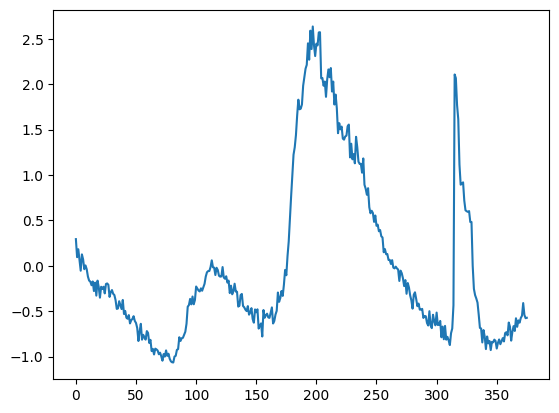

In [28]:
from scipy.stats import zscore
import matplotlib.pyplot as plt
import os

# --- Step 1: Feature Engineering & Z-scoring ---

# Underemployment ratio (slack)
Labor_Market_Distress_df['Involuntary_Part_Time_Rate'] = (
    Labor_Market_Distress_df['Part_Time_for_Economic_Reasons'] / Labor_Market_Distress_df['Employed']
)
Labor_Market_Distress_df['Involuntary_Part_Time_z'] = zscore(
    Labor_Market_Distress_df['Involuntary_Part_Time_Rate'], nan_policy='omit'
)

# Marginally attached as share of Not in Labor Force
Labor_Market_Distress_df['Marginal_Attachment_Rate'] = (
    Labor_Market_Distress_df['Marginally_Attached'] / Labor_Market_Distress_df['Not_in_Labor_Force']
) * 100
Labor_Market_Distress_df['Marginal_Attachment_z'] = zscore(
    Labor_Market_Distress_df['Marginal_Attachment_Rate'], nan_policy='omit'
)

# Z-score for duration of unemployment
Labor_Market_Distress_df['Median_Weeks_Unemployed_z'] = zscore(
    Labor_Market_Distress_df['Median_Weeks_Unemployed'], nan_policy='omit'
)

# Z-score for short-term unemployment rate (U2)
Labor_Market_Distress_df['U2_z'] = zscore(
    Labor_Market_Distress_df['U2_Unemployment_Rate'], nan_policy='omit'
)

# --- Step 2: Composite Labor Market Distress Index ---

Labor_Market_Distress_df['Labor_Market_Distress_Index'] = Labor_Market_Distress_df[[
    'Involuntary_Part_Time_z',
    'Marginal_Attachment_z',
    'Median_Weeks_Unemployed_z',
    'U2_z'
]].mean(axis=1, skipna=True)

Labor_Market_Distress_df['Labor_Market_Distress_Index'].plot()
Labor_Market_Distress_df.columns


Labor_Market_Distress_df['Distress_Label'] = pd.qcut(
    Labor_Market_Distress_df['Labor_Market_Distress_Index'],
    q=4,
    labels=['Low_Stress', 'Moderate', 'High_Distress', 'Severe_Distress']
)

Labor_Market_Distress_df